In [1]:
%%time
# Import necessary modules
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix


2024-06-02 14:20:05.749700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 14:20:05.749793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 14:20:05.849517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


CPU times: user 7.38 s, sys: 1.4 s, total: 8.78 s
Wall time: 12.4 s


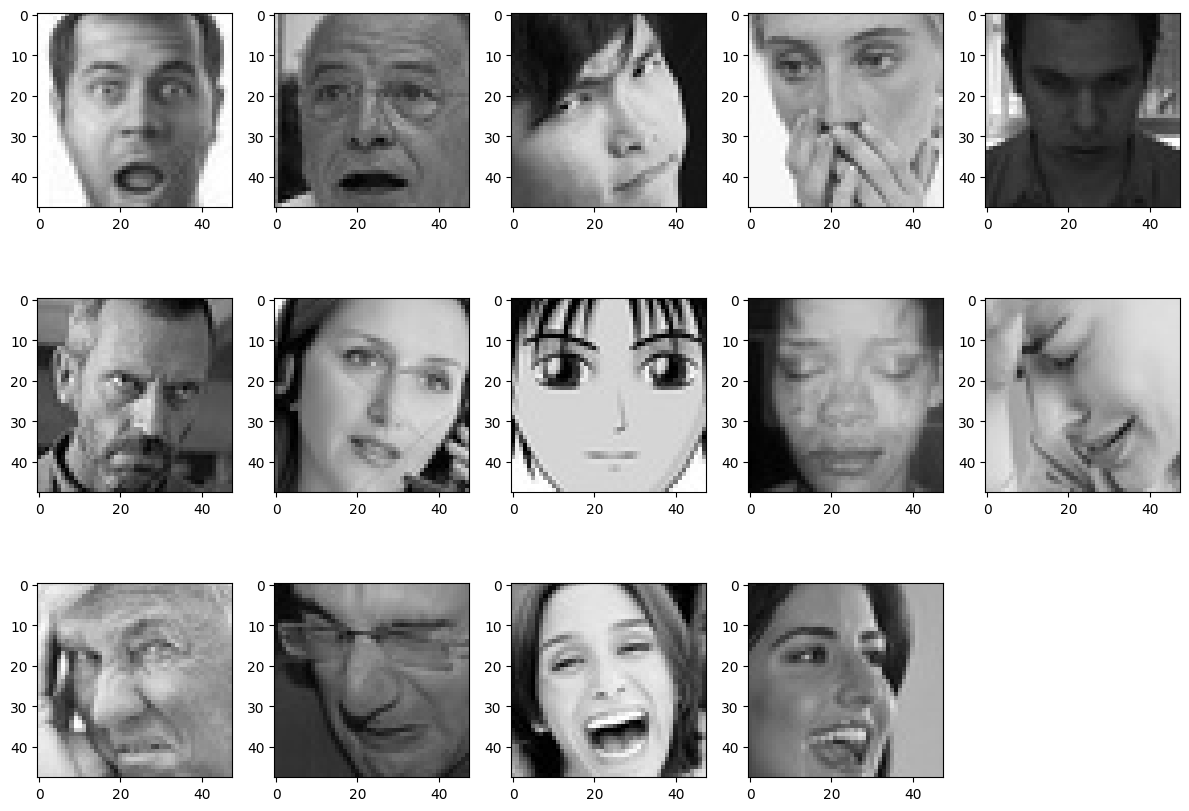

In [2]:
# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "../input/face-expression-recognition-dataset/images/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train"):
    for i in range(1,3):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path 
                              + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [3]:
# Các nhãn cảm xúc
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Hàm đếm số lượng ảnh trong từng thư mục con
def count_images_in_folder(folder_path):
    image_counts = {}
    for label in emotion_labels:
        image_folder = os.path.join(folder_path, label)
        num_images = len(os.listdir(image_folder))
        image_counts[label] = num_images
    return image_counts

# Đếm số lượng ảnh trong thư mục train và validation
train_image_counts = count_images_in_folder(os.path.join(base_path, 'train'))
validation_image_counts = count_images_in_folder(os.path.join(base_path, 'validation'))

# In ra số lượng ảnh
print("Số lượng ảnh trong thư mục train:")
print(train_image_counts)
print("\nSố lượng ảnh trong thư mục validation:")
print(validation_image_counts)


Số lượng ảnh trong thư mục train:
{'angry': 3993, 'disgust': 436, 'fear': 4103, 'happy': 7164, 'neutral': 4982, 'sad': 4938, 'surprise': 3205}

Số lượng ảnh trong thư mục validation:
{'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}


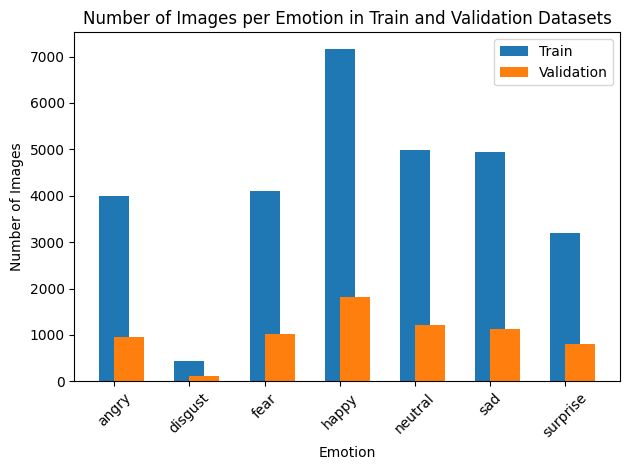

In [4]:
# Vẽ biểu đồ cột
def plot_image_counts(train_counts, validation_counts):
    labels = list(train_counts.keys())
    train_values = list(train_counts.values())
    validation_values = list(validation_counts.values())

    x = range(len(labels))

    fig, ax = plt.subplots()
    ax.bar(x, train_values, width=0.4, label='Train', align='center')
    ax.bar(x, validation_values, width=0.4, label='Validation', align='edge')

    ax.set_xlabel('Emotion')
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images per Emotion in Train and Validation Datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_image_counts(train_image_counts, validation_image_counts)

In [5]:
# Thiết lập đường dẫn tới tập dữ liệu của bạn
base_path = "../input/face-expression-recognition-dataset/images/"
input_shape = (48, 48, 1)
# Define emotion labels
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
num_classes = len(emotion_labels)

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load and preprocess the training and validation data
batch_size = 128
train_generator = train_datagen.flow_from_directory(
    base_path + "train",
    target_size=(pic_size, pic_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    base_path + "validation",
    target_size=(pic_size, pic_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [6]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# Define the CNN model architecture
model = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (5, 5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(num_classes, activation='softmax')
])

# Compile the model
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:

# Define callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
epochs = 50
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/225 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.1348 - loss: 2.4127   

I0000 00:00:1717338070.429238     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717338070.456333     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 14/225 ━━━━━━━━━━━━━━━━━━━━ 5:14 1s/step - accuracy: 0.1453 - loss: 2.3599 

W0000 00:00:1717338089.737569     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.1956 - loss: 2.1372

W0000 00:00:1717338214.351610     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.25923, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 195s 744ms/step - accuracy: 0.1958 - loss: 2.1364 - val_accuracy: 0.2592 - val_loss: 1.8948
Epoch 2/50
  1/225 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.2656 - loss: 1.9703

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.25923
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2656 - loss: 1.9703 - val_accuracy: 0.0000e+00 - val_loss: 3.6088
Epoch 3/50


W0000 00:00:1717338238.694325     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.2372 - loss: 1.9354
Epoch 3: val_accuracy improved from 0.25923 to 0.26179, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 43s 187ms/step - accuracy: 0.2372 - loss: 1.9353 - val_accuracy: 0.2618 - val_loss: 1.8648
Epoch 4/50
  1/225 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.2031 - loss: 1.9402
Epoch 4: val_accuracy did not improve from 0.26179
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 99us/step - accuracy: 0.2031 - loss: 1.9402 - val_accuracy: 0.0000e+00 - val_loss: 3.0518
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.2654 - loss: 1.8677
Epoch 5: val_accuracy improved from 0.26179 to 0.29957, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 43s 186ms/step - accuracy: 0.2654 - loss: 1.8677 - val_accuracy: 0.2996 - val_loss: 1.7577
Epoch 6/50
  1/225 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.2578 - loss: 2.0193
Epoch 6: val_accuracy did not improve from 0.29957
225/225 ━━━━━━━━━

In [8]:
# visualise training and testing accuracy and loss

def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    


    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
 
# print best epoch with best accuracy on validation

def get_best_epcoh(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

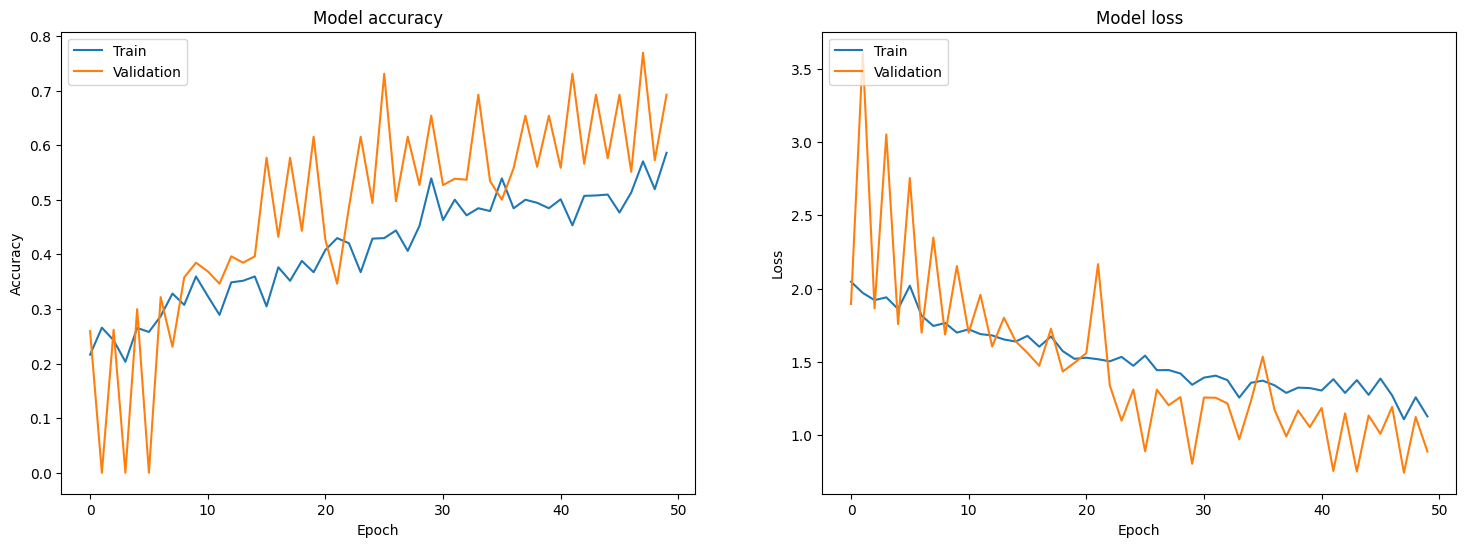

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

 4/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step 

W0000 00:00:1717339286.479468     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step


W0000 00:00:1717339292.424669     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


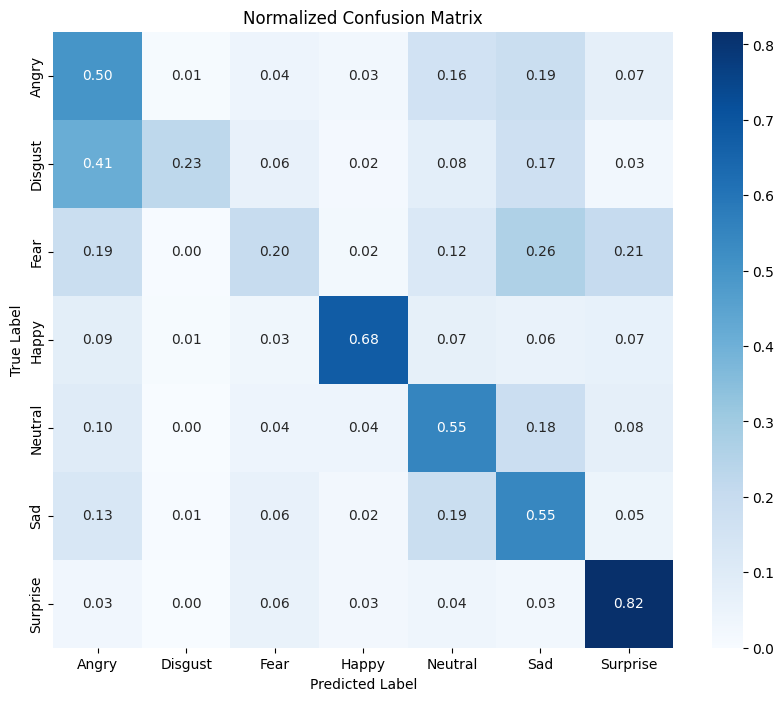

In [10]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model("best_model.keras")

# Generate predictions
Y_true = validation_generator.classes
Y_pred = best_model.predict(validation_generator, steps=validation_generator.n // validation_generator.batch_size + 1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Normalized Confusion Matrix')
plt.show()

In [11]:
def get_best_epcoh(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

In [12]:
best_epoch =get_best_epcoh(history)

Best Validation Accuracy Score 0.76923, is for epoch 48
